In [1]:
import pints
import pints.toy as toy

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras as keras

import string

# Problem parameters

In [2]:
# Create a model
real_model = pints.toy.FitzhughNagumoModel()

n_parameters = real_model.n_parameters()
n_outputs = real_model.n_outputs()
real_parameters = real_model.suggested_parameters()
#real_parameters = np.array([0.15, 500])

values, times, noise_stds = emutils.simulate(real_model,
                                             parameters=real_parameters
                                            )

# Create an object with links to the model and time series
# or Multioutput depending on problem
if n_outputs == 1:
    problem = pints.SingleOutputProblem(real_model, times, values)
else:
    problem = pints.MultiOutputProblem(real_model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
real_log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise_stds)

print("Number of parameters: ", n_parameters)
print("Parameter values: ", real_parameters)
print("Example problem values:\n", problem.values()[:5])

Number of parameters:  3
Parameter values:  [0.1 0.5 3. ]
Example problem values:
 [[-1.16757273  0.99914341]
 [-0.52961075  0.97806025]
 [ 0.99741436  1.05814345]
 [ 1.99879454  0.57026086]
 [ 1.89179931  0.30528865]]


In [3]:
# specify names for each parameter in the model
# default is alphabetical
index_to_param_name = dict(enumerate(string.ascii_lowercase[:n_parameters]))
index_to_param_name

{0: 'a', 1: 'b', 2: 'c'}

In [4]:
# creating distribution on bounds
# by default uniform with +-10% of original values
param_range = 0.2
real_params_lower = (1 - param_range) * real_parameters
real_params_upper = (1 + param_range) * real_parameters
#real_params_lower = [0.1, 400]
#real_params_upper = [0.2, 600]

bounds = pints.RectangularBoundaries(lower = real_params_lower, upper = real_params_upper)
log_prior = pints.UniformLogPrior(bounds)

print(list(zip(bounds.lower(), bounds.upper())))

[(0.08000000000000002, 0.12), (0.4, 0.6), (2.4000000000000004, 3.5999999999999996)]


# Toy problems contour graphs

Use to get an idea of continuity for high-dimensional inputs

In [5]:
fixed_parameters = emutils.fix_parameters(bounds)

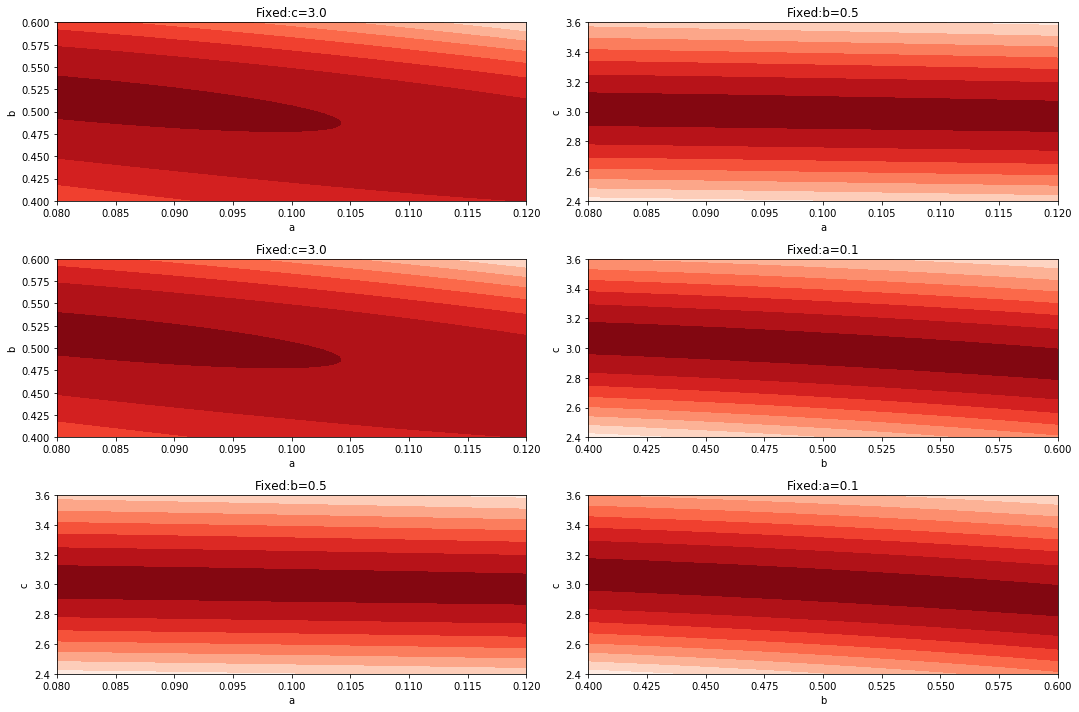

In [6]:
# row i has parameter i varying with every other parameter in the model
# however, x-axis is always taken by parameter that comes first in order
# i.e. lower index

if n_parameters > 2:  
    fig, ax = emuplt.plot_fixed_param_grid(
        real_log_likelihood,
        fixed_parameters,
        bounds,
        n_splits = 50, # number of splits on each free parameter
        shape = (n_parameters, n_parameters - 1),
    )

    plt.show(fig)

# Create dataset for training

In [7]:
# training size
training_size = 5000
test_size = 100

train_data = log_prior.sample(training_size)
train_target = np.apply_along_axis(real_log_likelihood, 1, train_data)

test_data = log_prior.sample(training_size)
test_target = np.apply_along_axis(real_log_likelihood, 1, test_data)

In [8]:
# normalize using standardisation for inputs

train_data_mean = np.mean(train_data, axis=0)
train_data_std = np.std(train_data, axis=0)

train_data_normalized = (train_data - train_data_mean) / train_data_std

# normalise test using same mean and var as train
test_data_normalized = (test_data - train_data_mean) / train_data_std


def normalize_input(x):
    return (x - train_data_mean) / train_data_std

# normalise target between [-1, 1]

train_target_min = np.min(train_target, axis = 0)
train_target_max = np.max(train_target, axis = 0)

train_target_normalized = 2 * (train_target - train_target_min) / (train_target_max - train_target_min) - 1
test_target_normalized = 2 * (test_target - train_target_min) / (train_target_max - train_target_min) - 1

def denormalize_prediction(x_norm):
    return (x_norm + 1) * (train_target_max - train_target_min) / 2 + train_target_min


# normalize data between [-1, 1] for output

# NN architectures

General rules:
* use identity for the last layer
* relu activation function
* Minimise squared error

In [9]:
def create_average_model():
    model = keras.Sequential()
    
    # shape [n_parameters, 5, 10, 5, 1]
    model.add(keras.layers.Dense(32, activation=tf.nn.relu, input_shape=(n_parameters,)))
    model.add(keras.layers.Dense(128, activation=tf.nn.relu))
    model.add(keras.layers.Dense(32, activation=tf.nn.relu))
    model.add(keras.layers.Dense(1, activation=tf.identity))
    
    return model

In [10]:
def create_small_model():
    model = keras.Sequential()
    
    model.add(keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(n_parameters,)))
    model.add(keras.layers.Dense(64, activation=tf.nn.relu))
    model.add(keras.layers.Dense(1, activation=tf.identity))
    # shape [1, 10, 50, 10, 1]
    return model

In [11]:
def create_large_model():
    model = keras.Sequential()
    
    model.add(keras.layers.Dense(256, activation=tf.nn.relu, input_shape=(n_parameters,)))
    model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dense(1, activation=tf.identity))
    
    return model

In [12]:
def create_model(name = "average"):
    if name == "small":
        return create_small_model()
    elif name == "average":
        return create_average_model()
    elif name == "large":
        return create_large_model
    else:
        raise "No NN architecture named " + name

# Create NN

In [13]:
# Hyperparameters
EPOCHS = 100
BATCH = 32
# learning_rate = 0.01

In [14]:
model = create_large_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 132,865
Trainable params: 132,865
Non-trainable params: 0
_________________________________________________________________


In [15]:
# use early stopping?


In [16]:
#optimizer = tf.train.RMSPropOptimizer(learning_rate)

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'] # mean absolute error
             )

In [17]:
history = model.fit(train_data_normalized, 
                    train_target_normalized, 
                    epochs=EPOCHS,
                    batch_size = BATCH,
                    validation_split=0.2,
                   )

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 1s 166us/step - loss: 0.0562 - mean_absolute_error: 0.1484 - val_loss: 0.0017 - val_mean_absolute_error: 0.0333
Epoch 2/100
4000/4000 [==============================] - 0s 81us/step - loss: 6.5825e-04 - mean_absolute_error: 0.0194 - val_loss: 3.5648e-04 - val_mean_absolute_error: 0.0149
Epoch 3/100
4000/4000 [==============================] - 0s 86us/step - loss: 6.5573e-04 - mean_absolute_error: 0.0196 - val_loss: 5.5791e-04 - val_mean_absolute_error: 0.0182
Epoch 4/100
4000/4000 [==============================] - 0s 76us/step - loss: 5.0128e-04 - mean_absolute_error: 0.0170 - val_loss: 2.8123e-04 - val_mean_absolute_error: 0.0130
Epoch 5/100
4000/4000 [==============================] - 0s 79us/step - loss: 6.3997e-04 - mean_absolute_error: 0.0189 - val_loss: 1.7551e-04 - val_mean_absolute_error: 0.0105
Epoch 6/100
4000/4000 [==============================] - 0s 91us/step - loss: 0

4000/4000 [==============================] - 0s 53us/step - loss: 1.6511e-04 - mean_absolute_error: 0.0095 - val_loss: 6.5623e-05 - val_mean_absolute_error: 0.0067
Epoch 48/100
4000/4000 [==============================] - 0s 56us/step - loss: 5.3406e-05 - mean_absolute_error: 0.0054 - val_loss: 1.6006e-05 - val_mean_absolute_error: 0.0031
Epoch 49/100
4000/4000 [==============================] - 0s 55us/step - loss: 2.2555e-04 - mean_absolute_error: 0.0101 - val_loss: 3.8738e-04 - val_mean_absolute_error: 0.0144
Epoch 50/100
4000/4000 [==============================] - 0s 58us/step - loss: 9.7198e-05 - mean_absolute_error: 0.0072 - val_loss: 3.5010e-05 - val_mean_absolute_error: 0.0044
Epoch 51/100
4000/4000 [==============================] - 0s 53us/step - loss: 2.5293e-05 - mean_absolute_error: 0.0039 - val_loss: 7.1958e-05 - val_mean_absolute_error: 0.0066
Epoch 52/100
4000/4000 [==============================] - 0s 51us/step - loss: 2.7017e-05 - mean_absolute_error: 0.0040 - val_lo

4000/4000 [==============================] - 0s 52us/step - loss: 2.8611e-05 - mean_absolute_error: 0.0039 - val_loss: 2.1427e-05 - val_mean_absolute_error: 0.0036
Epoch 94/100
4000/4000 [==============================] - 0s 52us/step - loss: 3.5552e-05 - mean_absolute_error: 0.0044 - val_loss: 9.6519e-05 - val_mean_absolute_error: 0.0070
Epoch 95/100
4000/4000 [==============================] - 0s 58us/step - loss: 2.1314e-04 - mean_absolute_error: 0.0105 - val_loss: 7.4724e-04 - val_mean_absolute_error: 0.0209
Epoch 96/100
4000/4000 [==============================] - 0s 52us/step - loss: 1.6582e-04 - mean_absolute_error: 0.0090 - val_loss: 3.6354e-05 - val_mean_absolute_error: 0.0050
Epoch 97/100
4000/4000 [==============================] - 0s 51us/step - loss: 3.2654e-05 - mean_absolute_error: 0.0043 - val_loss: 1.6833e-05 - val_mean_absolute_error: 0.0032
Epoch 98/100
4000/4000 [==============================] - 0s 52us/step - loss: 3.9083e-05 - mean_absolute_error: 0.0044 - val_lo

In [18]:
model.predict(normalize_input([real_parameters]))

array([[0.9937858]], dtype=float32)

In [19]:
loss, mae = model.evaluate(test_data_normalized, test_target_normalized)
print("Model loss: {:.10f}".format(loss))
print("Mean absolute error: {:.10f}".format(mae))

5000/5000 [==============================] - 0s 16us/step
Model loss: 0.0000098932
Mean absolute error: 0.0025106097


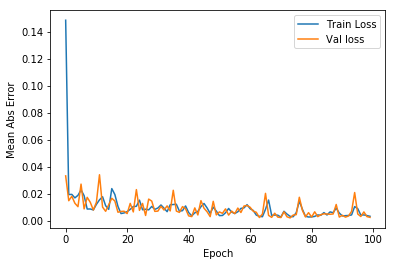

In [20]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
       label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
       label = 'Val loss')
plt.legend()

In [21]:
# calculate not normalized mean absolute error for test
test_prediction = denormalize_prediction(model.predict(test_data_normalized))
diff = np.mean(np.abs(test_prediction - train_target))
diff

451.2539630788647

# Plotting model

In [22]:
# create a callable object
def emu(x):
    return denormalize_prediction(model.predict(normalize_input(np.array([x]))))

In [23]:
# create a wrapper for our model
class EmulatorWrapper(pints.LogPDF):
    
    def __init__(self, emu, n_parameters):
        self._emu = emu
        self._n_parameters = n_parameters
    
    def __call__(self, x):
        return self._emu(x)
    
    def evaluateS1(self, x):
        pass
    
    def n_parameters(self):
        return self._n_parameters

In [24]:
emu = EmulatorWrapper(emu, n_parameters)

In [25]:
if n_parameters == 2:
    # generate data for surfaces
    test_splits = 20 # number of splits along each axis
    r_grid, k_grid, test_data = emutils.generate_grid(bounds.lower(), 
                                                      bounds.upper(), 
                                                      test_splits)    

    emu_grid = emutils.predict_grid(emu, test_data)
    real_grid = emutils.predict_grid(real_log_likelihood, test_data)

    plt.figure(figsize = (10, 5))
    ax = emuplt.surface(r_grid, k_grid, emu_grid, 
                        title = "True log_likelihood",
                        alpha = 0.8,
                        cmap="Blues",
                        x_label = "r (growth rate)",
                        y_label = "k (carrying capacity)"
                       )

    ax.plot_surface(r_grid, k_grid, real_grid, cmap="Reds", alpha = .5)

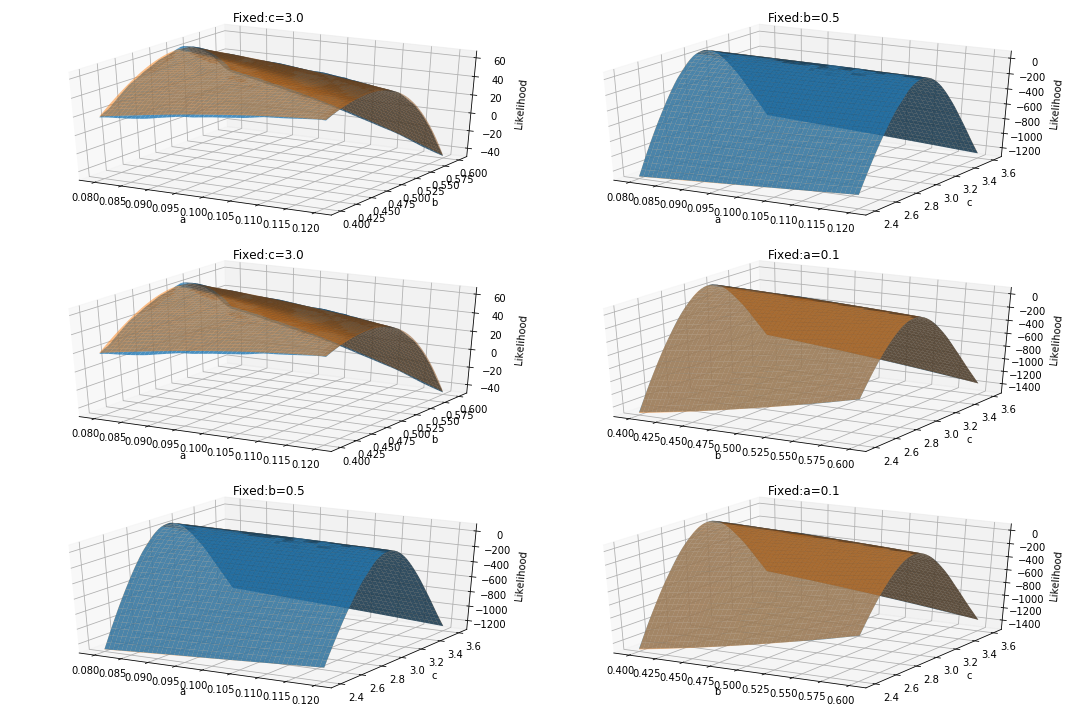

In [26]:
if n_parameters >=3:
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        n_splits = 50,
        shape = (n_parameters, n_parameters - 1),
        countour = False,
        additional_log_likelihoods = [real_log_likelihood]
    )

    plt.show(fig)
    
# for row i we have parameter i fixed and some other parameter j, depending on the column, j != i

# Timing single prediction

In [27]:
%%timeit
emu(real_parameters)

333 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
%%timeit
real_log_likelihood(real_parameters)

3.82 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Comparing MCMC run times

In [29]:
# Create a posterior log-likelihood (log(likelihood * prior))
emu_log_posterior = pints.LogPosterior(emu, log_prior)
real_log_posterior = pints.LogPosterior(real_log_likelihood, log_prior)

In [30]:
xs = [
    np.array(real_parameters) * 0.9,
    np.array(real_parameters) * 1.05,
    np.array(real_parameters) * 1.15,
]
xs

[array([0.09, 0.45, 2.7 ]),
 array([0.105, 0.525, 3.15 ]),
 array([0.115, 0.575, 3.45 ])]

In [31]:
chains = pints.mcmc_sample(emu_log_posterior, 3, xs)

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0          0:00.0
2     9      0         0.667     0          0:00.0
3     12     0         0.5       0.25       0:00.0
20    63     0.0952    0.0952    0.19       0:00.0
40    123    0.0732    0.0488    0.122      0:00.0
60    183    0.0492    0.0328    0.082      0:00.1
80    243    0.0494    0.037     0.0617     0:00.1
100   303    0.0495    0.0297    0.0495     0:00.1
120   363    0.0413    0.0331    0.0413     0:00.1
140   423    0.0355    0.0284    0.0355     0:00.1
160   483    0.0311    0.0248    0.0373     0:00.1
180   543    0.0331    0.0276    0.0331     0:00.2
Initial phase completed.
200   603    0.0348    0.0249    0.0348     0:00.2
220   663    0.0769    0.0724    0.0588     0:00.2
240   723    0.124     0.108     0.083      0:00.3
260   783    0.137931  0.119

3140  9423   0.206     0.205     0.212      0:04.1
3160  9483   0.207     0.205     0.212      0:04.1
3180  9543   0.207     0.206     0.212      0:04.1
3200  9603   0.208     0.207     0.211      0:04.2
3220  9663   0.208     0.208     0.21       0:04.2
3240  9723   0.21      0.208     0.211      0:04.2
3260  9783   0.209     0.208     0.211      0:04.2
3280  9843   0.209997  0.208     0.21       0:04.3
3300  9903   0.211     0.208     0.21       0:04.3
3320  9963   0.21      0.207     0.209      0:04.3
3340  10023  0.21      0.206525  0.21       0:04.3
3360  10083  0.21      0.207     0.209      0:04.4
3380  10143  0.209997  0.206     0.208      0:04.4
3400  10203  0.211     0.206     0.207292   0:04.4
3420  10263  0.21      0.206     0.207834   0:04.4
3440  10323  0.21      0.207     0.208079   0:04.5
3460  10383  0.21      0.208     0.209      0:04.5
3480  10443  0.21      0.208     0.209      0:04.5
3500  10503  0.212     0.208     0.209      0:04.5
3520  10563  0.212     0.208   

6360  19083  0.214     0.213     0.222      0:08.4
6380  19143  0.214073  0.212976  0.222      0:08.4
6400  19203  0.214     0.212623  0.222      0:08.4
6420  19263  0.214     0.212428  0.221928   0:08.5
6440  19323  0.215     0.212     0.222      0:08.5
6460  19383  0.214     0.211     0.221328   0:08.5
6480  19443  0.214     0.211     0.222      0:08.5
6500  19503  0.214     0.211     0.221      0:08.5
6520  19563  0.214     0.211     0.222      0:08.6
6540  19623  0.214     0.211     0.222      0:08.6
6560  19683  0.214449  0.21      0.222      0:08.6
6580  19743  0.214     0.21      0.222      0:08.7
6600  19803  0.213604  0.21      0.222      0:08.7
6620  19863  0.213     0.21      0.222625   0:08.7
6640  19923  0.213     0.21      0.222858   0:08.7
6660  19983  0.214     0.21      0.223      0:08.8
6680  20043  0.214     0.211     0.224      0:08.8
6700  20103  0.215     0.211     0.223698   0:08.8
6720  20163  0.215     0.211     0.224      0:08.9
6740  20223  0.215     0.211   

9600  28803  0.225     0.22      0.223      0:12.8
9620  28863  0.225     0.219     0.223      0:12.8
9640  28923  0.225     0.22      0.223      0:12.9
9660  28983  0.225     0.22006   0.223      0:12.9
9680  29043  0.225     0.22      0.222601   0:12.9
9700  29103  0.224616  0.22      0.223      0:12.9
9720  29163  0.224     0.22      0.222      0:13.0
9740  29223  0.224     0.22      0.222      0:13.0
9760  29283  0.224     0.22      0.222      0:13.0
9780  29343  0.224108  0.22      0.222      0:13.0
9800  29403  0.224     0.22      0.222      0:13.1
9820  29463  0.224     0.221     0.223      0:13.1
9840  29523  0.223     0.221     0.223      0:13.1
9860  29583  0.223     0.221     0.223      0:13.1
9880  29643  0.223     0.221     0.222      0:13.2
9900  29703  0.223     0.221     0.222      0:13.2
9920  29763  0.223     0.221     0.222      0:13.2
9940  29823  0.223217  0.221     0.222      0:13.2
9960  29883  0.22307   0.222     0.222      0:13.3
9980  29943  0.223     0.222   

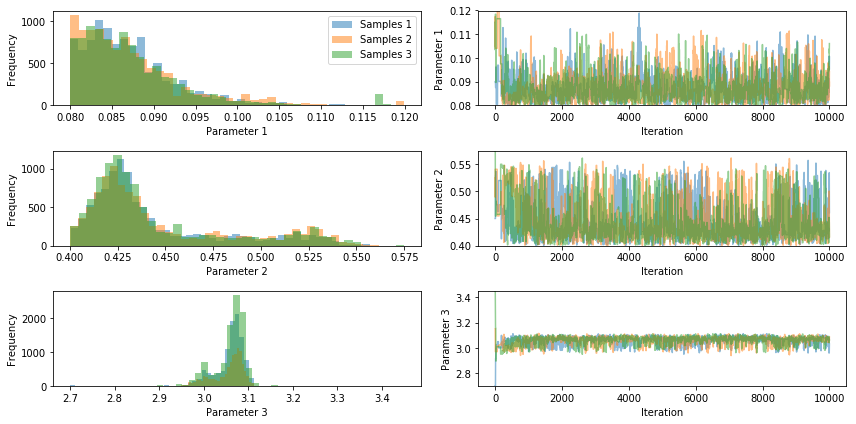

In [32]:
import pints.plot
pints.plot.trace(chains)
plt.show()

In [33]:
chains = pints.mcmc_sample(real_log_posterior, 3, xs)

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0.333     0         0          0:00.0
3     12     0.25      0.25      0          0:00.0
20    63     0.143     0.0952    0.19       0:00.1
40    123    0.0976    0.0976    0.146      0:00.2
60    183    0.0984    0.082     0.0984     0:00.3
80    243    0.111     0.0617    0.0864     0:00.4
100   303    0.099     0.0594    0.0693     0:00.5
120   363    0.0826    0.0496    0.0579     0:00.5
140   423    0.078     0.0426    0.0496     0:00.6
160   483    0.0683    0.0373    0.0435     0:00.7
180   543    0.0608    0.0331    0.0387     0:00.8
Initial phase completed.
200   603    0.0547    0.0299    0.039801   0:00.8
220   663    0.0905    0.0679    0.0633     0:01.1
240   723    0.116     0.116     0.0996     0:01.3
260   783    0.149     0.137

3120  9363   0.214     0.215636  0.211      0:23.9
3140  9423   0.214263  0.216     0.212      0:24.1
3160  9483   0.214     0.216     0.212      0:24.3
3180  9543   0.213     0.216     0.211      0:24.4
3200  9603   0.212746  0.216     0.212      0:24.6
3220  9663   0.214     0.217     0.213      0:24.8
3240  9723   0.214     0.217     0.214      0:24.9
3260  9783   0.213     0.217     0.215      0:25.1
3280  9843   0.213     0.217     0.215      0:25.2
3300  9903   0.213     0.216904  0.215      0:25.4
3320  9963   0.213     0.217     0.215      0:25.5
3340  10023  0.212     0.217     0.216      0:25.7
3360  10083  0.213     0.217     0.217      0:25.8
3380  10143  0.214     0.218     0.217      0:26.0
3400  10203  0.215     0.219     0.216995   0:26.2
3420  10263  0.215     0.218     0.218      0:26.4
3440  10323  0.215     0.219     0.219      0:26.5
3460  10383  0.214     0.219     0.219      0:26.7
3480  10443  0.213     0.219     0.219      0:26.8
3500  10503  0.214     0.219   

6360  19083  0.223     0.227     0.225      0:50.7
6380  19143  0.223     0.227     0.226      0:50.9
6400  19203  0.224     0.227     0.225      0:51.1
6420  19263  0.224     0.226     0.226      0:51.2
6440  19323  0.223723  0.226     0.226      0:51.4
6460  19383  0.223     0.226     0.226      0:51.6
6480  19443  0.222     0.226     0.226      0:51.7
6500  19503  0.222     0.226     0.226      0:51.9
6520  19563  0.222     0.225     0.226499   0:52.0
6540  19623  0.223     0.225     0.226418   0:52.2
6560  19683  0.223     0.225     0.227      0:52.4
6580  19743  0.223     0.225     0.227      0:52.6
6600  19803  0.223     0.225     0.227      0:52.8
6620  19863  0.223     0.225     0.227      0:53.0
6640  19923  0.223     0.224665  0.227526   0:53.1
6660  19983  0.223     0.224     0.227      0:53.3
6680  20043  0.223     0.224     0.227      0:53.4
6700  20103  0.223     0.224     0.227      0:53.6
6720  20163  0.223     0.223     0.226752   0:53.7
6740  20223  0.223     0.223409

9600  28803  0.224     0.229     0.228      1:16.5
9620  28863  0.223     0.229     0.228      1:16.6
9640  28923  0.223     0.229     0.228607   1:16.8
9660  28983  0.223     0.229     0.229      1:16.9
9680  29043  0.223     0.229     0.229      1:17.1
9700  29103  0.223     0.229     0.229      1:17.2
9720  29163  0.223     0.229606  0.229      1:17.4
9740  29223  0.223     0.229     0.229      1:17.6
9760  29283  0.223     0.229     0.229      1:17.8
9780  29343  0.223     0.229     0.23       1:17.9
9800  29403  0.223     0.229     0.23       1:18.1
9820  29463  0.223     0.229     0.229      1:18.3
9840  29523  0.223     0.229     0.229245   1:18.4
9860  29583  0.223     0.229     0.229      1:18.6
9880  29643  0.223     0.229     0.23       1:18.7
9900  29703  0.223     0.229     0.23       1:18.8
9920  29763  0.223     0.229     0.23       1:19.0
9940  29823  0.223     0.229     0.23       1:19.2
9960  29883  0.22307   0.229     0.23       1:19.3
9980  29943  0.223     0.228434

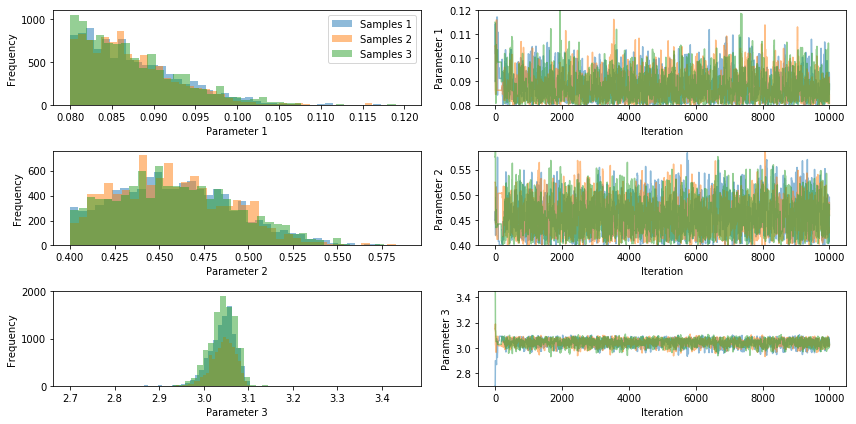

In [34]:
pints.plot.trace(chains)
plt.show()

In [35]:
chain = chains[0]

emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
real_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()

diffs = np.abs(real_prediction - emu_prediction)

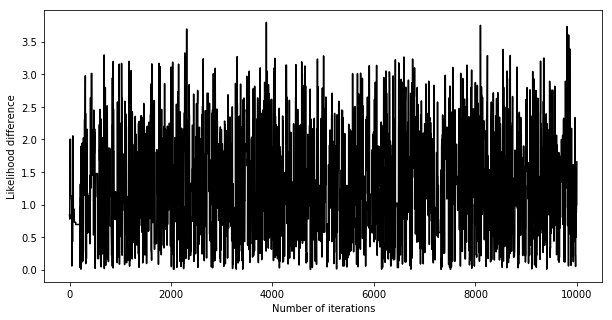

In [36]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood difference")
plt.plot(iters, diffs, color = "Black")
plt.show()